# Problem 6 - Phase Identification(2)

## Agenda
- Problem Description
- Problem Implementation
- Wrap-Up

## Problem Description
- <b>Consider $N$ customers whose connection phase assumes one out of three possible labels $a$, $b$, or $c$ and estimate the correct customer-to-label assignment based on $M$ readings whose per-phase values are a function of the corresponding phase-connected individual customer reading.

Considered network
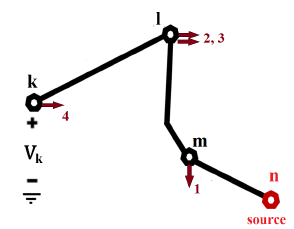

<b>Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Parameters

In [2]:
cosPhi=0.95
time=48
m=12
netFactor=0.25
noiseFactor=0.00

<b>Initial data

In [3]:
#Consumption dataset
s=  [[0.0450,    0.0150,    0.0470,    0.0330],
     [0.0250,    0.0150,    0.2480,    0.0330],
     [0.0970,    0.0250,    0.3940,    0.0330],
     [0.0700,    0.0490,    0.0200,    0.4850],
     [0.1250,    0.0460,    0.0160,    0.1430],
     [0.2900,    0.0270,    0.0160,    0.0470],
     [0.2590,    0.0150,    0.0170,    0.0200],
     [0.2590,    0.0160,    0.0280,    0.0160],
     [0.4420,    0.0160,    0.0500,    0.0170],
     [0.2010,    0.0230,    0.0460,    0.0160],
     [0.2060,    0.0490,    0.0220,    0.0240],
     [0.1300,    0.0470,    0.0160,    0.0490],
     [0.0460,    0.0260,    0.0170,    0.0480]]
s = np.array(s)

#topology
topo=[[1, 2],[2,3],[3,4]]
nBUS=np.max(topo)

#Impedance
z=np.multiply([complex(0.1,0.05),complex(0.15,0.07),complex(0.2,0.1)],netFactor)

vr=1 #Reference voltage
el=1
ni=20 #Iterations for the Power Flow




<b>Power Flow Function

In [4]:
def pf3ph(t,z,si,vr,el,ni,al):
    #Matrices creation
    t=np.array(t)
    p=t[:,0]
    f=t[:,1]
    w=len(p)+1
    vp=np.zeros((nBUS-1,w), dtype=complex)
    vn=np.zeros((nBUS-1,w), dtype=complex)
    vp[0,0:w]=vr
    
    for h in range (2,nBUS):
        vp[h-1,:]=vp[h-2,:]*al  #Create a three phase system of voltages
                                #Voltages will be the same in all BUS

    va=vp-vn                                                      #Auxiliar voltage
    ia=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))      #Auxiliar current 
    
    for it in range(ni):                                          #Iterations of Power Flow
        va=vp-vn
        ip=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))  #Phase current 
        inn=-np.sum(ip,0)                                         #Neutral current 
        for k in range(w-1,0,-1):                                 #Backward Cycle
            n=f[k-1]
            m=p[k-1]
            ip[:,m-1]=ip[:,m-1]+ip[:,n-1]                         #Phase Current
            inn=-np.sum(ip,0)                                     #Neutral Current

        eps= np.linalg.norm(np.max(np.abs(ia-ip),0))              #Error, comparing the new currents and the old ones (previous iteration)

        if eps>1e-4:
            ia=ip
            mvp=0
            mvn=0
            eps=np.inf
        else:                       #If the error is lower than the limit, we can return the results 
            mvp=(vp-vn)             #Phase Voltages to return
            mvn=vn[0,:]             #Neutral Voltage to return
#            return mvp, mvn, eps, ip, inn;
            return mvp
        for k in range (w-1):                     #Forward Cycle
            n=f[k]                                
            m=p[k]
            vn[:,n-1]=vn[:,m-1]-z[k]*inn[n-1]     #Neutral Voltage 
            vp[:,n-1]=vp[:,m-1]-z[k]*ip[:,n-1]    #Phase Voltage
        ia=ip             #Save the current of previous iteration


<b> Compute the values of voltages obtained by PMUs

In [5]:
#Creation of Matrices
al=np.exp(np.multiply(np.multiply(complex(0,-1),2/3),np.pi)) #Phase Angle
Y=np.zeros((3*m), dtype=complex)
X=np.zeros((3*m,m), dtype=complex)
v=np.zeros((m,3))
dv_abs=np.zeros((m,3))


for i in range(m):
    si=[[0, 0, s[i,2], 0],[0, 0, s[i,1], 0],[0, s[i,0],  0, s[i,3]]] #Connection of consumers by
                                                                     #node and by phase
                                                                     #Consumer 1 (s[i,0]) is 
                                                                     #connected to Bus 2 in Phase 3
    mvp=pf3ph(topo,z,si,vr,el,ni,al)
    noise=1+noiseFactor*np.random.randn(3)
    mvp[:,3]=np.multiply(mvp[:,3],noise)                       #Add noise to the voltages
    Y[3*(i):3*(i)+3]=mvp[:,3]                                  #Save the voltages in matrix Y
    dv_abs[i,:]=vr-np.abs(mvp[:,3])                            #Volage variations (only to plot)

Volt=np.reshape(Y,(m,3))   

print ('The voltages measured in the PMUs are:\n',Volt)

The voltages measured in the PMUs are:
 [[ 0.99866484-0.00476962j -0.49831414-0.86835917j -0.49392011+0.85964588j]
 [ 0.97290228-0.01601085j -0.51139766-0.87380016j -0.50744349+0.85456696j]
 [ 0.95608633-0.02441701j -0.51885398-0.87750207j -0.51325967+0.84910673j]
 [ 1.04767033-0.03551787j -0.45091668-0.89757332j -0.40102796+0.79332501j]
 [ 1.01576499-0.00999985j -0.48302166-0.87236861j -0.46567302+0.84426734j]
 [ 1.00968654-0.00695356j -0.48918564-0.87063669j -0.47774451+0.85167455j]
 [ 1.00602188-0.005418j   -0.49284148-0.869901j   -0.48483326+0.85566688j]
 [ 1.00423842-0.00571336j -0.4939299 -0.86980129j -0.48633757+0.85598497j]
 [ 1.00578779-0.00995392j -0.4910006 -0.87340185j -0.4790803 +0.84942259j]
 [ 1.0006834 -0.00538471j -0.49631931-0.86845387j -0.49010362+0.8577634j ]
 [ 1.00475844-0.00282624j -0.4936193 -0.86480633j -0.48660002+0.8589564j ]
 [ 1.00631448-0.00319825j -0.49244873-0.86549546j -0.48460471+0.85781421j]]


<b> Sum of Impedences
    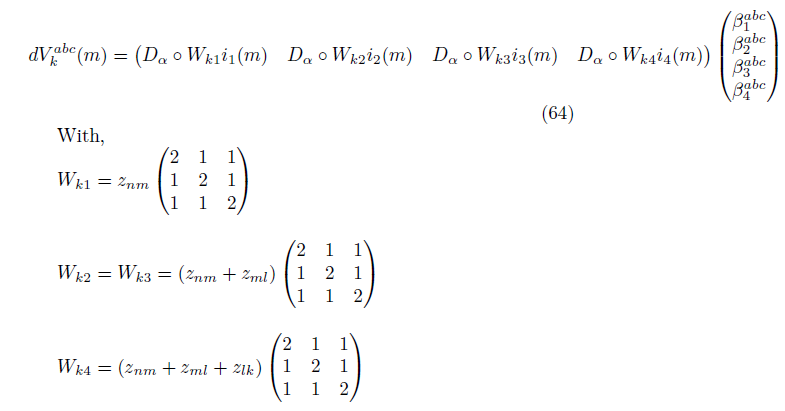

In [90]:
#The value of Z is the multiplication between D and W but not considering the values of z_nm;z_ml and zlk
Z = np.array([[2, al, al**2],[1, 2*al, al**2],[1, al, 2*al**2]])
z = np.array([0.025 +0.0125j, 0.0375+0.0175j, 0.05  +0.025j])

W1 = z[0] * Z
W2=W3 = (z[0] + z[1]) * Z
W4 = (z[0] + z[1] + z[2]) * Z

W = [W1, W2, W3, W4]
# Initialize X as a 12x4 array of empty 3x3 matrices
X = np.empty((36,12), dtype=complex)

<b>Complex Expansion
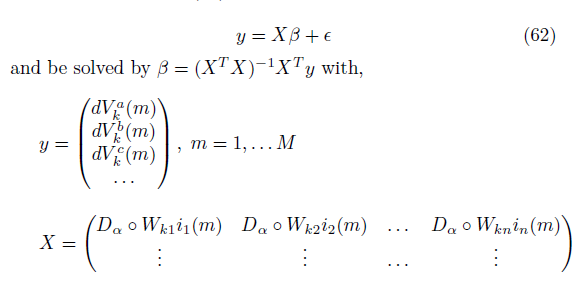

In [91]:
# Matrices CReation
vz=np.zeros(3*m, dtype=complex)
vz_abs=np.zeros(3*m, dtype=complex)

#Compute dVk for each time period m   
for i in range (m):
    vz[3*(i):3*(i)+3]= np.multiply(vr,[1, al, al**2] ) -  Y[3*(i):3*(i)+3]    #With PMUs info
    vz_abs[3*(i):3*(i)+3]=np.multiply(vr-np.absolute(Y[3*(i):3*(i)+3]),[1, al, al**2])   #With RTUs info

Beta_PMUS = np.empty((12, 1), dtype=complex)
Beta_RTUS = np.empty((12, 1), dtype=complex)

#Compute X matrix considering different W (Please use the value Z)
#| x x x | | x x x | | x x x | | x x x |
#| x x x | | x x x | | x x x | | x x x |
#| x x x | | x x x | | x x x | | x x x |

for j in range(m):
    for l in range(3):
        for k in range(4):
            W_aux = W[k]
            for i in range(3):
                X[j*3+l,k*3+i] = W_aux[l,i] * s[j, k]


X_H = np.conj(X.T)  # Hermitian transpose of X

Beta_PMUS = np.linalg.inv(X_H @ X) @ X_H @ vz                 #Betas with PMUs info

Beta_RTUS = np.linalg.inv(X_H @ X) @ X_H @ vz_abs               #Betas with RTUs info


In [93]:
Bpmu = Beta_PMUS
Brtu = Beta_RTUS

print('Betas (complex) considering information from PMUs\n', Bpmu, '\n')
print('Betas (complex) considering information from RTUs\n', Brtu, '\n')

BBpmu = Beta_PMUS.real
BBrtu = Beta_RTUS.real

print('Betas considering information from PMUs\n', BBpmu, '\n')
print('Betas considering information from RTUs\n', BBrtu, '\n')

Betas (complex) considering information from PMUs
 [ 8.48911918e-05+0.00267591j  8.94505723e-06+0.00087075j
  9.99814476e-01-0.01316107j  6.53417371e-05+0.00639303j
  1.00006576e+00+0.00013459j  3.17600231e-03+0.12282283j
  9.99748077e-01-0.02222942j -2.17365356e-06-0.00108381j
 -3.89139777e-05+0.00779855j -4.46213141e-06-0.00031504j
 -1.75636093e-05+0.00173224j  9.98299908e-01-0.06083752j] 

Betas (complex) considering information from RTUs
 [-0.54691574-0.18190167j  0.30851159+0.48237617j  1.03295766-0.69775125j
  0.31034131+0.5394602j   1.16243864-0.73869221j -0.5802952 -0.22916067j
  1.05334089-0.67256294j -0.53183608-0.20467905j  0.2838925 +0.49065128j
 -0.54323727-0.21232642j  0.25524374+0.50777213j  1.05809936-0.67194189j] 

Betas considering information from PMUs
 [ 8.48911918e-05  8.94505723e-06  9.99814476e-01  6.53417371e-05
  1.00006576e+00  3.17600231e-03  9.99748077e-01 -2.17365356e-06
 -3.89139777e-05 -4.46213141e-06 -1.75636093e-05  9.98299908e-01] 

Betas considering i

<b>Graphics

In [95]:
x = np.arange(m)
y1=dv_abs
y2=s[0:12,:]

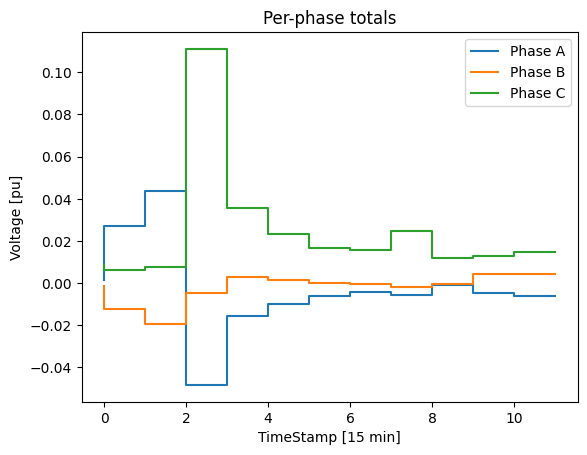

In [100]:
#Graph 1
plt.step(x,y1,label=['Phase A','Phase B','Phase C'])
plt.xlabel('TimeStamp [15 min]')
plt.ylabel('Voltage [pu]')
plt.title('Per-phase totals')
plt.legend()
plt.show()

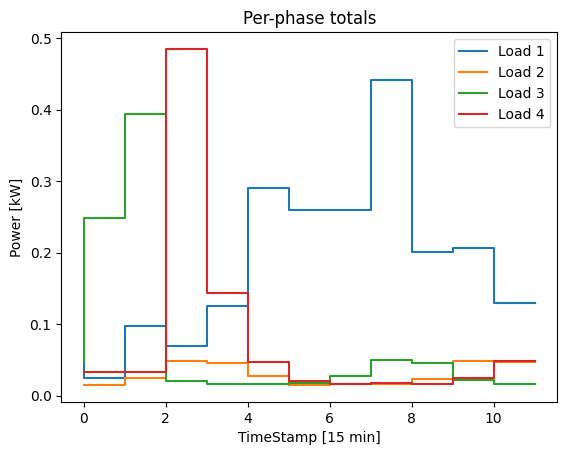

In [101]:
#Graph 2
plt.step(x,y2,label=['Load 1','Load 2','Load 3','Load 4'])
plt.xlabel('TimeStamp [15 min]')
plt.ylabel('Power [kW]')
plt.title('Per-phase totals')
plt.legend()
plt.show()